**Импорт необходимых библиотек**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

**Загрузка данных**

In [28]:
train_df = pd.read_csv('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Просмотр наличие дисбаланса целевой переменной**

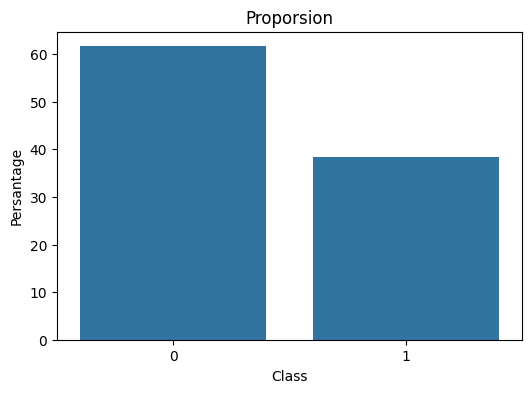

In [29]:
proporsion = train_df['Survived'].value_counts(normalize=True)
plt.figure(figsize=(6,4))
sns.barplot(x=proporsion.index, y=proporsion.values * 100)
plt.title('Proporsion')
plt.xlabel('Class')
plt.ylabel('Persantage')
plt.show()

Для оценки модели будем использовать метрику f1, так как денные по целевой переменнной не сбалансированы, также для бинарной классификации f1 подходил лучше

**Предобработка данных**

In [30]:
# Просмотр пропусков в каждом столбце

train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Заполним пропуски по возрасту путем вычисления среднего значения в каждой группе. Для этого найдем обращение для каждого пассажира и запишем в столбец *FirstName*

In [31]:
def extract_first_personal_name(full_name):
    parts = full_name.split(", ") # Избавляемся от места отбытия
    if len(parts) > 1:
        first_part = parts[1].split(".")[0]  # Получение заголовка (Mr./Mrs.)
        personal_names = first_part.strip() 
        return personal_names
    return ""

In [32]:
train_df["FirstName"] = train_df["Name"].apply(extract_first_personal_name)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


Объединим некоторые малы группы в большие

In [33]:
replace_map = {
    'Rev' : 'Mr' ,
    'Col' : 'Mr',
    'Dr' : 'Mr',
    'Major' : 'Mr',
    'Don' : 'Mr',
    'Capt' : 'Mr',
    'Dona' : 'Mrs',
    'Countess' : 'Mrs',
    'Ms': 'Miss',
    'Mlle': 'Miss'
}
train_df['FirstName'] = train_df['FirstName'].replace(replace_map, regex=True)

Заполним пропущенные значения по возрасту, вычислив средние значения в каждой группе, которые определили ранее

In [34]:
grouped_mean_ages = train_df.groupby('FirstName')['Age'].mean().to_dict()
def fill_missing_age(row):
    if pd.isnull(row['Age']):  # Проверяем, есть ли пропуск
        return grouped_mean_ages[row['FirstName']]  # Возвращаем среднее значение для FirstName
    else:
        return row['Age']
train_df['Age'] = train_df.apply(fill_missing_age, axis=1)

In [35]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,Mr
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.845638,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr


Удалим ненужные столбцы

* **PassengerId** - ID пассажира, не несет в себе важной информации
* **Name** - имя пассажира
* **Ticket** - номер билета
* **Cabin** - номер каюты
* **Embarked** - порт, в котором призошла пасадка пассажира
* **FirstName** - ранее созданный столбец для заполнения пропущенных значений

In [36]:
# Удаление ненужных столбцов
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'FirstName'], axis=1)

Разделение набора данных

In [37]:
# Разделение на признаки и целевую переменную
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Разбиение на train/test (random_state для воспроизводимости)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Бейзлайн**

In [38]:
# Бейзлайн (предсказание самого частого класса)
baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
print("F1-score бейзлайна:", f1_score(y_test, y_pred_baseline))

F1-score бейзлайна: 0.0


ML-классификатор

In [40]:
# Определение числовых и категориальных признаков
numeric_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch']

# Пайплайн для предобработки и модели
model = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )),
    ('classifier', LogisticRegression(random_state=42))
])

# Обучение и предсказание
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Оценка модели
print("F1-score модели:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

F1-score модели: 0.75177304964539

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

